# Calibração

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import peakutils
import sys

sys.path.insert(0, "../")

from peakutils.plot import plot as pplot
from scipy.optimize import curve_fit
from scipy.signal import gaussian
from scipy.ndimage import filters

from common import *
from pprint import pprint

%matplotlib inline

## Calibração usando o espectro do Na22

Primeiramente carregamos os dados e as linhas detectadas pelo programa de aquisição. Selecionamos manualmente as linhas nos canais 200, 420 e 600, aproximadamente, correspondentes às transições nucleares de 511 keV, 1274.5 keV e ao caso em que, num intervalo de tempo muito curto, um fóton de 511 keV e um de 1274.5 keV são absorvidos pelo cristal de NaI(Tl), gerando um pulso com a energia combinada de 511+1274.5=1785.5 keV.

Utilizando os valores conhecidos das energias dos três picos citados, pretendemos calibrar o espectro supondo que a energia é um polinômio de grau dois no número do canal.

In [2]:
arquivos = {
    'na22': '../../dados/na22_15032017_1622.tsv',
    #'co57': os.path.join(data_dir, 'co57_15032017_1734.tsv'),
    'cd109': os.path.join(data_dir, 'cd109_15032017_1653.tsv'),
    'mn54': os.path.join(data_dir, 'mn54_15032017_1624.tsv'),
    'co60': os.path.join(data_dir, 'co60_15032017_1752.tsv'),
}

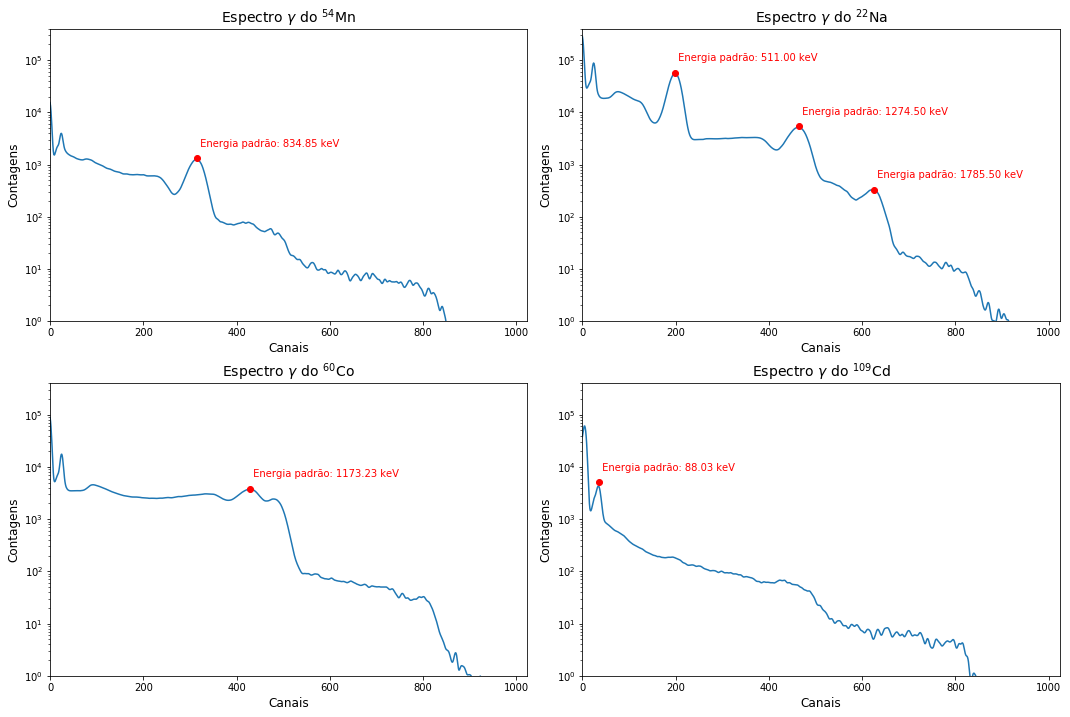

In [10]:
energias_padrao = {
    'na22': [511, 1274.5, 1785.5],
    #'co57': [136.47],
    'cd109': [88.03],
    'mn54': [834.85],
    'co60': [1173.23],
    
}
picos_selecionados = {
    'na22': np.array([1, 3, 4]),
    #'co57': np.array([0]),
    'cd109': np.array([0]),
    'mn54':np.array([0]),
    'co60': np.array([2]),
}
canais_calibracao = []
erros_calibracao = []
energias_calibracao = []

fig = plt.figure(figsize=(15, 10))
for k, amostra in enumerate(arquivos):
    ax = fig.add_subplot(len(arquivos)/2, 2, k + 1)
    fig.tight_layout()
    ax.set_ylim([1, 400000])
    ax.set_xlim([0, 1024])
    ax.set_yscale('log')
    
    # carrega e suaviza dados para amostra
    canais, contagens = load_data(arquivos[amostra])
    contagens_smooth = smooth(contagens, 3)
    
    # carrega picos da amostra
    canais_picos, contagens_picos, canais_err = get_peak_points(arquivos[amostra], amostra, cut=0, return_channel=True)
    canais_picos = canais_picos[picos_selecionados[amostra]]
    contagens_picos = contagens_picos[picos_selecionados[amostra]]
    
    # obtêm energia padrão e desvio dos picos
    energia_padrao = energias_padrao[amostra]
    
    # plota
    amostra_latex = r"${}^{" + amostra[2:] + "}$" + amostra[0].upper() + amostra[1]
    title = "Espectro $\gamma$ do " + amostra_latex
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Canais", fontsize=12)
    ax.set_ylabel("Contagens", fontsize=12)
    _ = ax.plot(canais, contagens_smooth)
    
    for i, canal in enumerate(canais_picos):
        err_canal = canais_err[i]
        energia = energia_padrao[i]
        _ = ax.plot(canal, contagens_picos[i], 'ro')
        point_label = " Energia padrão: {:.2f} keV\n".format(energia)
        ax.text(canal, contagens_picos[i], point_label, color='red')
        
        #salva para calibracao
        canais_calibracao.append(canal)
        erros_calibracao.append(err_canal)
        energias_calibracao.append(energia)
    fig.savefig("espectros_amostras_calibracao.pdf")

Também plotamos o espectro acima, com os picos indicados pelo programa de coleta de dados (ICS10).

Calibramos a energia dos espectros fazendo um ajuste quadrático aos três pontos encontrados (note que não é possível estimar os erros, pois temos tantos pontos quanto graus de liberdade). Nos gráficos abaixo, vemos nosso ajuste, e os valores encontrados para os parâmetros $A$, $B$ e $C$ do ajuste

$$ \text{energia} = A\cdot\text{canal}^2 + B\cdot\text{canal} + C $$

[0.00065399021388590196, 2.4428725069775155, 0.93272750621480793]
[1.9877198078802282e-05, 0.013487706847085503, 2.0263553043923088]
chi_sq:  6504.2730509


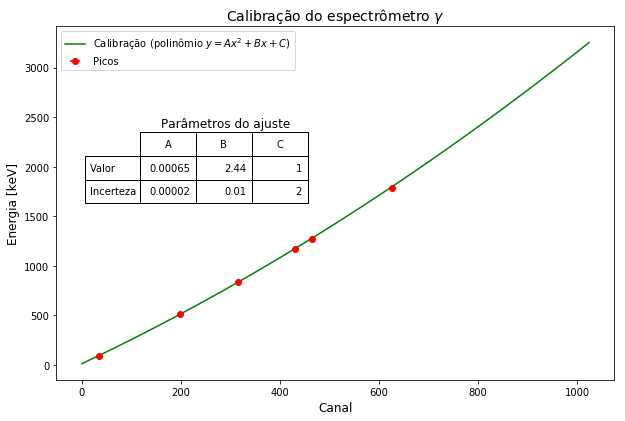

In [21]:
pvar, pcov = curve_fit(lambda x, A, B, C: A*x**2 + B*x + C, 
                       canais_calibracao, energias_calibracao)

perr = np.sqrt(np.diag(pcov))
channels = np.linspace(0, 1024, 1024)
energies = calibracao(channels, pvar)

chi_sq = np.sum(((energias_calibracao - calibracao(canais_calibracao, pvar)) / erros_calibracao) ** 2) / len(canais_calibracao)
pprint(list(pvar))
pprint(list(perr))
print("chi_sq: ", chi_sq)

fig = plt.figure(figsize=(10, 6.5))
ax = fig.add_subplot(111)
ax.set_xlabel('Canal', fontsize=12)
ax.set_ylabel('Energia [keV]', fontsize=12)
A = "{:.5f}".format(pvar[0])
B = "{:.2f}".format(pvar[1])
C = "{:.0f}".format(pvar[2])
err_A = "{:.5f}".format(perr[0])
err_B = "{:.2f}".format(perr[1])
err_C = "{:.0f}".format(perr[2])

ax.table(cellText=[[A, B, C], [err_A, err_B, err_C]],
        colLabels=["A", "B", "C"],
        rowLabels=["Valor", "Incerteza"],
        loc='center left',
        bbox=[0.15, 0.50, 0.30, 0.20],
        fontsize=12)
ax.text(160, 2400, 'Parâmetros do ajuste', size=12)
ax.errorbar(canais_calibracao, energias_calibracao, xerr=erros_calibracao, fmt='ro', label='Picos ')
ax.plot(channels, energies, 'g', label='Calibração (polinômio $y = Ax^2 + Bx + C$)')
ax.set_title("Calibração do espectrômetro $\gamma$", fontsize=14)
ax.legend()
fig.savefig("ajuste_calibracao.png")

In [15]:
print(erros_calibracao)

[0.14281365640090427, 0.24649868319637042, 0.071444528314778669, 1.0898402802093006, 0.40318567471670891, 0.04403449556853662]


## Checagem da calibração utilizando o espectro do Cs-137

A fim de checar a calibração obtida anteriormente, tomamos o espectro de uma fonte de Cs-137 e checamos o valor obtido para a energia do pico principal, que deve corresponder à transição de 661.6 keV do Cs.

In [5]:
arquivo = "../../dados/cs137_15032017_1705.tsv"
canais_cs = np.loadtxt(arquivo, delimiter='\t', skiprows=26, usecols=(0,))
contagens_cs = np.loadtxt(arquivo, delimiter='\t', skiprows=26, usecols=(1,))
energias_cs = calibracao_ics(canais_cs)

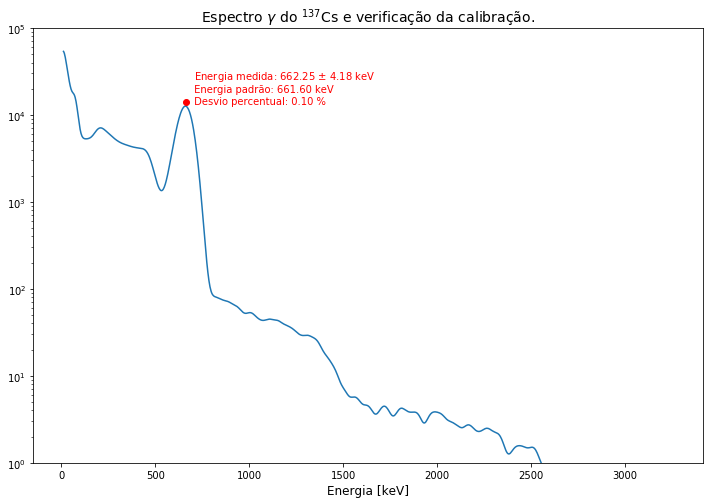

In [36]:
contagens_cs_smooth = smooth(contagens_cs, 6)

index_cs = peakutils.indexes(contagens_cs_smooth, thres=0.0001, min_dist=140)[1]
xs_cs = energias_cs[index_cs]
ys_cs = contagens_cs_smooth[index_cs]

canais_picos, contagens_picos, err_canais_picos = get_peak_points(arquivo, 'cs137', cut=0, return_channel=True)
energia_pico = calibracao(canais_picos, pvar)[1]
err_energia_pico = np.sqrt(
    ((2 * pvar[0] * canais_picos[1] + pvar[1]) * err_canais_picos[1]) ** 2 +
    (perr[0] * canais_picos[1] ** 2) ** 2 +
    (perr[1] * canais_picos[1]) ** 2 + 
    (perr[2]) ** 2
)
contagem_pico = contagens_picos[1]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.plot(energias_cs, contagens_cs_smooth)
ax.set_xlabel("Energia [keV]", fontsize=12)
ax.set_ylim([1, 100000])
energia_padrao = 661.60
peak_label = " Energia medida: {:.2f} $\pm$ {:.2f} keV \n Energia padrão: {:.2f} keV \n Desvio percentual: {:.2f} %".format(
    energia_pico, err_energia_pico, energia_padrao, np.abs(energia_pico - energia_padrao)/energia_padrao*100)
ax.text(energia_pico+30, contagem_pico+30, peak_label, color='red')
ax.set_title("Espectro $\gamma$ do ${}^{137}$Cs e verificação da calibração.", fontsize=14)
_ = ax.plot(energia_pico, contagem_pico, 'ro')
fig.savefig("verificacao_calibracao.pdf")

Os erros de ambas calibrações estão na ordem de 0.2-0.3 %, validando a calibração (para energias próximas a ~600 keV).